# `FL002_linearization`

In [3]:
%load_ext watermark
%watermark -a "Etienne Ackermann," -n -t -v -p nelpy,numpy,scipy,pandas

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Etienne Ackermann, Fri Dec 01 2017 23:55:04 

CPython 3.6.3
IPython 6.1.0

nelpy 0.1.1
numpy 1.12.1
scipy 0.19.1
pandas 0.21.0


In [2]:
import numpy as np # primary math library
import matplotlib.pyplot as plt # primary plotting library
import numpy as np
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
# %matplotlib notebook
# %matplotlib qt5

%matplotlib inline

import nelpy as nel # should be installed using pip install nelpy
import nelpy.plotting as npl

import warnings
#warnings.filterwarnings("ignore") # useful to prevent excess nelpy warnings

C:\Users\etien\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


In [3]:
fileroot = '../../../../neoReader/'
FrankLabData = nel.load_pkl(fileroot + 'FrankLabData-BonConFra-no-eeg01.nel') # saved with Pandas=0.21
data = FrankLabData.data
sessions = FrankLabData.sessions

In [6]:
FrankLabVertexData = nel.load_pkl(fileroot + 'FrankLabVertexData.nel')
vertexData = FrankLabVertexData.vertexData

# Linearization idea [linearization vs idealization]

For each point, we identify the closest line segment from the idealized, skeletonized W-maze (that, is, we find the closest segment, `a` through `e`). When more than one line segment is equally close to the current point, then we should raise a UserWarning, and assign the point to the segment closest to it in a neighborhood of time.  Indeed, one idea is to do the segment-assignment on a heavily smoothed trajectory, and then to do the final projection using the raw, unsmoothed data.

Vertices for the w-maze are numbered as follows:
```python
"""W-maze vertex ordering
   1     2     3
   |     |     |
   a     b     c
   |     |     |
   4--d--5--e--6
"""
```

Thereafter, we project each point to its closest line segment. There will be two orderings that we will consider, namely 2 -> 5 -> (4, 6) -> (1, 3), so-called center-outer ordering (`co-ordering`) and 1 -> 4 -> 5 -> 6 -> 3, so-called outer-outer ordering (`oo-ordering`).

**Question:** wat should I do about points on the center arm, during outer-outer ordering? Probably the most consitent thing to do is to let points on edge b be interleaved with points on edge e. No special treament.

At any rate, when the points are projected onto their assigned segments, that represents an _idealized_ trajectory, and not yet a _linearized_ trajectory. It might be nice to view decoded trajectories in this idealized space though.

Linearization is then finally achieved by computing, for each point, the shortest travel distance (along the segments) from vertex (2) for center-outer ordering, and from vertex (1) for outer-outer ordering, to the current point.

Since I don't plan to take special care to make this code blazingly fast (yet), the results should definitely be saved.

In [7]:
def make_segments_from_vertices(vertexData, animal, day, env='E1'):
    """make line segments from vertices
    
    a segment is of shape [[x0, y0], [x1, y2]]
    
    segments is of shape [[[x0, y0], [x1, y2]],
                                  ...
                          [[x0, y0], [x1, y2]]]
                          
    i.e., shape (n_segments, 2, 2)
                          
    W-maze vertex ordering and segment labeling

    1     2     3
    |     |     |
    a     b     c
    |     |     |
    4--d--5--e--6
    """
    
    v1, v2, v3, v4, v5, v6 = vertexData[animal][day][env]
    
    a = [v1, v4]
    b = [v2, v5]
    c = [v3, v6]
    d = [v4, v5]
    e = [v5, v6]
    
    vertices = np.array([v1, v2, v3, v4, v5, v6])
    segments = np.array([a,b,c,d,e])
    
    return segments, vertices

In [8]:
def point_to_line_segment_dist(point, line_segment):
    """Calculate the distance between a point and a line segment.

    To calculate the closest distance to a line segment, we first need to check
    if the point projects onto the line segment.  If it does, then we calculate
    the orthogonal distance from the point to the line.
    If the point does not project to the line segment, we calculate the 
    distance to both endpoints and take the shortest distance.

    :param point: Numpy array of form [x,y], describing the point.
    :type point: numpy.core.multiarray.ndarray
    :param line: list of endpoint arrays of form [P1, P2]
    :type line: list of numpy.core.multiarray.ndarray
    :return: The minimum distance to a point.
    :rtype: float
    """
    # unit vector
    unit_line = line_segment[1] - line_segment[0]
    norm_unit_line = unit_line / np.linalg.norm(unit_line)

    # compute the perpendicular distance to the theoretical infinite line
    segment_dist = (
        np.linalg.norm(np.cross(line_segment[1] - line_segment[0], line_segment[0] - point)) /
        np.linalg.norm(unit_line)
    )

    diff = (
        (norm_unit_line[0] * (point[0] - line_segment[0][0])) + 
        (norm_unit_line[1] * (point[1] - line_segment[0][1]))
    )

    x_seg = (norm_unit_line[0] * diff) + line_segment[0][0]
    y_seg = (norm_unit_line[1] * diff) + line_segment[0][1]

    endpoint_dist = min(
        np.linalg.norm(line_segment[0] - point),
        np.linalg.norm(line_segment[1] - point)
    )

    # decide if the intersection point falls on the line segment
    lp1_x = line_segment[0][0]  # line point 1 x
    lp1_y = line_segment[0][1]  # line point 1 y
    lp2_x = line_segment[1][0]  # line point 2 x
    lp2_y = line_segment[1][1]  # line point 2 y
    is_betw_x = lp1_x <= x_seg <= lp2_x or lp2_x <= x_seg <= lp1_x
    is_betw_y = lp1_y <= y_seg <= lp2_y or lp2_y <= y_seg <= lp1_y
    if is_betw_x and is_betw_y:
        return segment_dist
    else:
        # if not, then return the minimum distance to the segment endpoints
        return endpoint_dist

In [9]:
def get_closest_segments(pts, segments):
    """for each point in the trajectory, determine the segment assignment (with smoothing and warning on ties)"""
    # TODO: warning not yet issued on ties
    
    if isinstance(pts, nel.AnalogSignalArray):
        pts = pts.ydata.T
        
    n_pts = len(pts)
    n_segments = len(segments)
    
    dist_to_segments = np.zeros((n_pts, n_segments))

    for ss, segment in enumerate(segments):
        for pp, point in enumerate(pts):
            dist_to_segments[pp, ss] = point_to_line_segment_dist(point, segment)
    
    segment_assignments = np.argmin(dist_to_segments, axis=1, )
    return segment_assignments

In [10]:
def project_onto_segments(points, segments, segment_assignments):
    """for each point, project onto assigned segment (this is idealized position, not linearized yet!)
    
    x1, x2, x3 = 5, 20, -25
    y1, y2, y3 = 5, 35, -30

    dx = x2 - x1
    dy = y2 - y1
    d2 = dx*dx + dy*dy
    nx = ((x3-x1)*dx + (y3-y1)*dy) / d2

    # restrict to line segment:

    nx = min(1, max(0, nx))

    x = (x2 - x1) * nx + x1
    y = (y2 - y1) * nx + y1
    """
    
    if isinstance(points, nel.AnalogSignalArray):
        pts = points.ydata.T
    else:
        pts = points
        
    n_pts = len(pts)
    n_segments = len(segments)
    
    idealized = np.zeros((n_pts,2))
    
    for ss, segment in enumerate(segments):
        subset = np.argwhere(segment_assignments==ss).squeeze()
        pts_for_segment = pts[subset,:]
    
        x3, y3 = pts_for_segment[:,0], pts_for_segment[:,1]

        segment = segments[ss]

        dx = segment[1,0] - segment[0,0]
        dy = segment[1,1] - segment[0,1]
        d2 = dx*dx + dy*dy

        nx = ((x3-segment[0,0])*dx + (y3-segment[0,1])*dy) / d2

        # restrict to line segment:
        nx[nx>1] = 1
        nx[nx<0] = 0

        x = dx*nx + segment[0,0]
        y = dy*nx + segment[0,1]
        
        idealized[subset,0] = x
        idealized[subset,1] = y
        
    if isinstance(points, nel.AnalogSignalArray):
        from copy import deepcopy
        out = deepcopy(points)
        out._ydata = idealized.T
        idealized = out
    
    return idealized

In [11]:
def linearize_from_center_arm(points, vertices, segment_assignments):
    """linearization is obtained by computing the TRAVEL-DISTANCE
    (not euclidean or Manhattan!) from vertex (2) to each point
    
    1     2     3
    |     |     |
    a     b     c
    |     |     |
    4--d--5--e--6
    
    """
    
    if isinstance(points, nel.AnalogSignalArray):
        pts = points.ydata.T
    else:
        pts = points
        
    v1, v2, v3, v4, v5, v6 = vertices
        
    n_pts = len(pts)
    n_segments = len(segments)
    
    linearized = np.zeros(n_pts)
    
    to_a = np.argwhere(segment_assignments==0).squeeze()
    to_b = np.argwhere(segment_assignments==1).squeeze()
    to_c = np.argwhere(segment_assignments==2).squeeze()
    to_d = np.argwhere(segment_assignments==3).squeeze()
    to_e = np.argwhere(segment_assignments==4).squeeze()
    
    pts_to_a = pts[to_a,:]
    pts_to_b = pts[to_b,:]
    pts_to_c = pts[to_c,:]
    pts_to_d = pts[to_d,:]
    pts_to_e = pts[to_e,:]
    
    entire_b = np.linalg.norm(v2-v5)
    entire_d = np.linalg.norm(v4-v5)
    entire_e = np.linalg.norm(v6-v5)
    
    # b to b
    dist_on_b = np.linalg.norm(v2 - pts_to_b, axis=1)
    linearized[to_b] = dist_on_b
    
    # b to e
    dist_on_e = np.linalg.norm(v5 - pts_to_e, axis=1)
    linearized[to_e] = entire_b + dist_on_e
    
    # b to c [bec]
    dist_on_c = np.linalg.norm(v6 - pts_to_c, axis=1)
    linearized[to_c] = entire_b + entire_e + dist_on_c
    
    # b to d
    dist_on_d = np.linalg.norm(v5 - pts_to_d, axis=1)
    linearized[to_d] = entire_b + dist_on_d
    
    # b to a [bda]
    dist_on_a = np.linalg.norm(v4 - pts_to_a, axis=1)
    linearized[to_a] = entire_b + entire_d + dist_on_a
    
    if isinstance(points, nel.AnalogSignalArray):
        from copy import deepcopy
        out = deepcopy(points)
        out._ydata = np.atleast_2d(linearized.T)
        linearized = out
    
    return linearized

In [12]:
def linearize_from_outer_arm(points, segments, segment_assignments):
    """linearization is obtained by computing the TRAVEL-DISTANCE
    (not euclidean or Manhattan!) from vertex (1) to each point
    
    1     2     3
    |     |     |
    a     b     c
    |     |     |
    4--d--5--e--6

    """
    
    if isinstance(points, nel.AnalogSignalArray):
        pts = points.ydata.T
    else:
        pts = points
        
    v1, v2, v3, v4, v5, v6 = vertices
        
    n_pts = len(pts)
    n_segments = len(segments)
    
    linearized = np.zeros(n_pts)
    
    to_a = np.argwhere(segment_assignments==0).squeeze()
    to_b = np.argwhere(segment_assignments==1).squeeze()
    to_c = np.argwhere(segment_assignments==2).squeeze()
    to_d = np.argwhere(segment_assignments==3).squeeze()
    to_e = np.argwhere(segment_assignments==4).squeeze()
    
    pts_to_a = pts[to_a,:]
    pts_to_b = pts[to_b,:]
    pts_to_c = pts[to_c,:]
    pts_to_d = pts[to_d,:]
    pts_to_e = pts[to_e,:]
    
    entire_a = np.linalg.norm(v1-v4)
    entire_d = np.linalg.norm(v4-v5)
    entire_e = np.linalg.norm(v6-v5)
       
    # a to a
    dist_on_a = np.linalg.norm(v1 - pts_to_a, axis=1)
    linearized[to_a] = dist_on_a
    
    # a to d
    dist_on_d = np.linalg.norm(v4 - pts_to_d, axis=1)
    linearized[to_d] = entire_a + dist_on_d
    
    # a to e [ade]
    dist_on_e = np.linalg.norm(v5 - pts_to_e, axis=1)
    linearized[to_e] = entire_a + entire_d + dist_on_e
    
    # a to c [adec]
    dist_on_c = np.linalg.norm(v6 - pts_to_c, axis=1)
    linearized[to_c] = entire_a + entire_d + entire_e + dist_on_c
    
    # a to b [adb]
    dist_on_b = np.linalg.norm(v5 - pts_to_b, axis=1)
    linearized[to_b] = entire_a + entire_d + dist_on_b
    
    if isinstance(points, nel.AnalogSignalArray):
        from copy import deepcopy
        out = deepcopy(points)
        out._ydata = np.atleast_2d(linearized.T)
        linearized = out
    
    return linearized
    

# Idealization and linearization demo

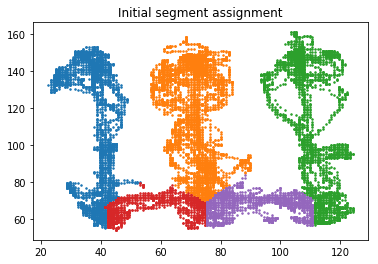

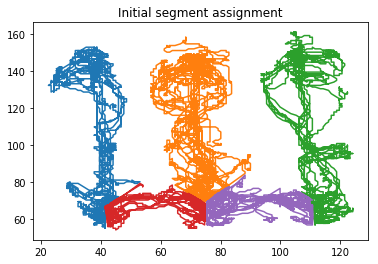

In [36]:
segment_assignments = get_closest_segments(pos.smooth(sigma=0.), segments)

xvals, yvals = pos.asarray().yvals
for ss in range(len(segments)):
    subset = np.argwhere(segment_assignments==ss).squeeze()
    plt.plot(xvals[subset], yvals[subset], '.', markersize=3)
plt.title('Initial segment assignment')
plt.show()

for ss in range(len(segments)):
    subset = np.argwhere(segment_assignments==ss).squeeze()
    plt.plot(xvals[subset], yvals[subset])
plt.title('Initial segment assignment')
plt.show()

**Remarks:** notice that the "closest-segment-to-point" rule introduces some incorrect segment assignments, and discontinuities in the trajectories. We'll fix that below.

d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


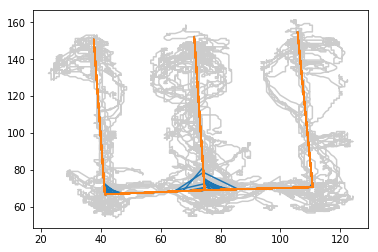

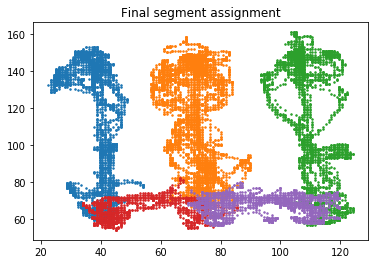

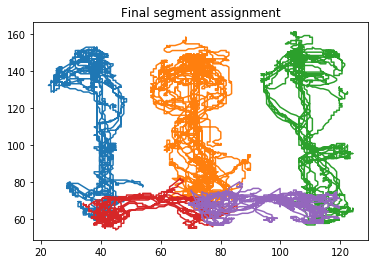

In [35]:
animal, day = 'Bon', 'Day3'
pos = data[animal][day]['pos'][1] # E1a run session

# obtain w-maze vertices, in w-maze order, create w-maze segments
segments, vertices = make_segments_from_vertices(vertexData=vertexData, 
                                       animal=animal, 
                                       day=day, 
                                       env='E1')

# for each point in the trajectory, determine the segment assignment (with smoothing and warning on ties)
segment_assignments = get_closest_segments(pos.smooth(sigma=0.5), segments)

# for each point, project onto assigned segment (this is idealized position, not linearized yet!)
idealized = project_onto_segments(pos, segments, segment_assignments)

npl.plot2d(pos, color='0.8')
npl.plot2d(idealized)

# TRICK! We apply the same algorithm again, with aggressive smoothing to idealized,
# to fix some of the corner assignments:

segment_assignments = get_closest_segments(idealized.smooth(sigma=1.2), segments)
idealized = project_onto_segments(idealized, segments, segment_assignments)
segment_assignments = get_closest_segments(idealized.smooth(sigma=0.2), segments)
idealized = project_onto_segments(idealized, segments, segment_assignments)
npl.plot2d(idealized)
plt.show()

xvals, yvals = pos.asarray().yvals
for ss in range(len(segments)):
    subset = np.argwhere(segment_assignments==ss).squeeze()
    plt.plot(xvals[subset], yvals[subset], '.', markersize=3)
plt.title('Final segment assignment')
plt.show()

for ss in range(len(segments)):
    subset = np.argwhere(segment_assignments==ss).squeeze()
    plt.plot(xvals[subset], yvals[subset])
plt.title('Final segment assignment')
plt.show()

# linearize
linpos_co = linearize_from_center_arm(idealized, vertices, segment_assignments)
linpos_oo = linearize_from_outer_arm(idealized, vertices, segment_assignments)

# npl.plot(linpos_co.smooth(sigma=0.5), label='center-outer ordering')
# npl.plot(linpos_oo.smooth(sigma=0.5), label='outer-outer ordering')

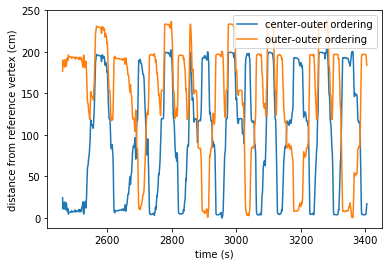

In [38]:
ax = npl.plot(linpos_co.smooth(sigma=0.5), label='center-outer ordering')
npl.plot(linpos_oo.smooth(sigma=0.5), label='outer-outer ordering')
ax.set_xlabel('time (s)')
ax.set_ylabel('distance from reference vertex (cm)')
plt.legend()

**Remarks:** notice how in the final segment assignment above, the trajectories are now continuous and consistent! That's cool!

# Idealize and linearize all epochs

In [37]:
for animal, day in sessions:
    print(animal, day)
    data[animal][day]['pos_linear_center_ordering'] = dict()
    data[animal][day]['pos_linear_outer_ordering'] = dict()
    data[animal][day]['pos_ideal'] = dict()
    
    task_run_epochs = data[animal][day]['task_metadata'].query('type=="run"').Epoch.values
    
    for epidx in task_run_epochs:
        if (epidx == 1) or (epidx == 3):
            env = 'E1'
        elif epidx == 5:
            env = 'E2'
        else:
            raise ValueError('linearization of task epoch {} not supported!'.format(epidx))
    
        pos = data[animal][day]['pos'][[epidx],:]

        # obtain w-maze vertices, in w-maze order, create w-maze segments
        segments, vertices = make_segments_from_vertices(vertexData=vertexData, 
                                                         animal=animal, 
                                                         day=day, 
                                                         env=env)

        # for each point in the trajectory, determine the segment assignment (with smoothing and warning on ties)
        segment_assignments = get_closest_segments(pos.smooth(sigma=0.5), segments)

        # for each point, project onto assigned segment (this is idealized position, not linearized yet!)
        idealized = project_onto_segments(pos, segments, segment_assignments)

        # TRICK! We apply the same algorithm again, with aggressive smoothing to idealized,
        # to fix some of the corner assignments:

        segment_assignments = get_closest_segments(idealized.smooth(sigma=1.2), segments)
        idealized = project_onto_segments(idealized, segments, segment_assignments)
        segment_assignments = get_closest_segments(idealized.smooth(sigma=0.2), segments)
        idealized = project_onto_segments(idealized, segments, segment_assignments)

        # linearize
        linpos_co = linearize_from_center_arm(idealized, vertices, segment_assignments)
        linpos_oo = linearize_from_outer_arm(idealized, vertices, segment_assignments)
        
        data[animal][day]['pos_linear_center_ordering'][epidx] = linpos_co
        data[animal][day]['pos_linear_outer_ordering'][epidx] = linpos_oo
        data[animal][day]['pos_ideal'][epidx] = idealized

Bon Day2


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Bon Day3


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Bon Day4


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Bon Day5


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Bon Day6


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Bon Day7


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Bon Day8


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Bon Day9


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Con Day0


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Con Day1


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Con Day2


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Con Day3


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Con Day4


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Con Day5


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Fra Day1


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Fra Day2


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Fra Day3


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Fra Day4


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Fra Day5


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Fra Day6


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Fra Day7


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Fra Day8


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Fra Day9


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Fra Day10


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Fra Day11


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


### Save augmented data

In [38]:
FrankLabData = nel.ResultsContainer(data=data,
                                    sessions=FrankLabData.sessions,
                                    cellinfo=FrankLabData.cellinfo,
                                    taskinfo=FrankLabData.taskinfo,
                                    tetinfo=FrankLabData.tetinfo,
                                    description=FrankLabData.descriptioncription)
FrankLabData.save_pkl(fileroot + 'FrankLabData-BonConFra-no-eeg02.nel')

# Supplemental: Manually annotate vertices on w-maze

Maze position has nice initialization! Compare, for example, `('Bon', 'Day3', epoch_ids=[1,3])` with `('Fra', 'Day4', epoch_ids=[1,3])`


In [10]:
vertexData = {}

In [11]:
import numpy as np
import math

# def dot_auv(a,u,v):
#     c = v[0]-u[0], v[1]-u[1]
#     cnorm = np.sqrt(c[0]*c[0] + c[1]*c[1])
#     dot = (c[1]*(a[1]-u[1]) + c[0]*(a[0]-u[0])) / cnorm
#     return dot

# def proj_auv(u,v,t):
#     c = v[0]-u[0], v[1]-u[1]
#     cnorm = np.sqrt(c[0]*c[0] + c[1]*c[1])
#     return t*c[0]/cnorm + u[0],t*c[1]/cnorm+u[1]

def center_of_mass(points):
    """
    Finds the center of mass of a set of points.
    
    points should be array-liks with shape (n_pts, 2)
    """
    
    return np.mean(points, axis=0)

def rotate_pt(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def rotate_pts(origin, points, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    
    points should be array-liks with shape (n_pts, 2)
    """
    rotated = []
    for point in points:
        rot = rotate_pt(origin=origin,
                       point=point,
                       angle=angle)
        rotated.append(rot)
    
    return np.array(rotated)

def save_vertices(datadict, vertices):
    
    vert_order = [0,6,4,1,2,3]
    
    if epoch_ids == [1,3]:
        try:
            datadict[animal][day]['E1'] = vertices[vert_order]
        except KeyError:
            try:
                datadict[animal][day] = dict()
                datadict[animal][day]['E1'] = vertices[vert_order]
            except KeyError:
                datadict[animal] = dict()
                datadict[animal][day] = dict()
                datadict[animal][day]['E1'] = vertices[vert_order]
        except NameError:
            datadict = dict()
            datadict[animal] = dict()
            datadict[animal][day] = dict()
            datadict[animal][day]['E1'] = vertices[vert_order]
    elif epoch_ids == 5:
        try:
            datadict[animal][day]['E2'] = vertices[vert_order]
        except KeyError:
            try:
                datadict[animal][day] = dict()
                datadict[animal][day]['E2'] = vertices[vert_order]
            except KeyError:
                datadict[animal] = dict()
                datadict[animal][day] = dict()
                datadict[animal][day]['E2'] = vertices[vert_order]
        except NameError:
            datadict = dict()
            datadict[animal] = dict()
            datadict[animal][day] = dict()
            datadict[animal][day]['E2'] = vertices[vert_order]
    else:
        raise ValueError('unknown epoch_ids')

class PathInteractor(object):
    """
    An path editor.

    Key-bindings

      't' toggle vertex markers on and off.  When vertex markers are on,
          you can move them, delete them
          
      'r' rotate vertices 45 degrees counter-clockwise around center of mass
      
      'z' save vertices to data dictionary ('s' is already bound by matplotlib Qt)


    """

    showverts = True
    epsilon = 5  # max pixel distance to count as a vertex hit

    def __init__(self, pathpatch, datadict={}):

        self.datadict = datadict
        self.ax = pathpatch.axes
        canvas = self.ax.figure.canvas
        self.pathpatch = pathpatch
        self.pathpatch.set_animated(True)

        x, y = zip(*self.pathpatch.get_path().vertices)

        self.line, = ax.plot(x, y, marker='o', color='none',
                             markerfacecolor='r', animated=True)

        self._ind = None  # the active vert

        canvas.mpl_connect('draw_event', self.draw_callback)
        canvas.mpl_connect('button_press_event', self.button_press_callback)
        canvas.mpl_connect('key_press_event', self.key_press_callback)
        canvas.mpl_connect('button_release_event', self.button_release_callback)
        canvas.mpl_connect('motion_notify_event', self.motion_notify_callback)
        self.canvas = canvas

    def draw_callback(self, event):
        self.background = self.canvas.copy_from_bbox(self.ax.bbox)
        self.ax.draw_artist(self.pathpatch)
        self.ax.draw_artist(self.line)
        self.canvas.blit(self.ax.bbox)

    def pathpatch_changed(self, pathpatch):
        'this method is called whenever the pathpatchgon object is called'
        # only copy the artist props to the line (except visibility)
        vis = self.line.get_visible()
        plt.Artist.update_from(self.line, pathpatch)
        self.line.set_visible(vis)  # don't use the pathpatch visibility state

    def get_ind_under_point(self, event):
        'get the index of the vertex under point if within epsilon tolerance'

        # display coords
        xy = np.asarray(self.pathpatch.get_path().vertices)
        xyt = self.pathpatch.get_transform().transform(xy)
        xt, yt = xyt[:, 0], xyt[:, 1]
        d = np.sqrt((xt - event.x)**2 + (yt - event.y)**2)
        ind = d.argmin()

        if d[ind] >= self.epsilon:
            ind = None

        return ind

    def button_press_callback(self, event):
        'whenever a mouse button is pressed'
        if not self.showverts:
            return
        if event.inaxes is None:
            return
        if event.button != 1:
            return
        self._ind = self.get_ind_under_point(event)

    def button_release_callback(self, event):
        'whenever a mouse button is released'
        if not self.showverts:
            return
        if event.button != 1:
            return
        self._ind = None

    def key_press_callback(self, event):
        'whenever a key is pressed'
        if not event.inaxes:
            return
        if event.key == 't':
            self.showverts = not self.showverts
            self.line.set_visible(self.showverts)
            if not self.showverts:
                self._ind = None
        if event.key == 'r': # rotate vertices 15 degrees counter-clockwise
            vertices = self.pathpatch.get_path().vertices
            pivot = center_of_mass(vertices)
            new_verts = rotate_pts(origin=pivot,
                                   points=vertices,
                                   angle=math.radians(45))
            
            vertices[:] = new_verts
            self.line.set_data(zip(*new_verts))
            self.canvas.restore_region(self.background)
            self.ax.draw_artist(self.pathpatch)
            self.ax.draw_artist(self.line)
#             self.canvas.blit(self.ax.bbox)   
            if not self.showverts:
                self._ind = None
        if event.key == 'z': # save vertices to data dict
            vertices = self.pathpatch.get_path().vertices
            print('saving vertices for {} {} epochs {}'.format(animal, day, epoch_ids))
            save_vertices(self.datadict, vertices)

        self.canvas.draw()

    def motion_notify_callback(self, event):
        'on mouse movement'
        if not self.showverts:
            return
        if self._ind is None:
            return
        if event.inaxes is None:
            return
        if event.button != 1:
            return
        x, y = event.xdata, event.ydata

        vertices = self.pathpatch.get_path().vertices

        vertices[self._ind] = x, y
        
        if self._ind == 2: # technically the same vertex as 5!
            vertices[5] = vertices[2]
    
        if self._ind == 5: # technically the same vertex as 2!
            vertices[2] = vertices[5]

        self.line.set_data(zip(*vertices))

        self.canvas.restore_region(self.background)
        self.ax.draw_artist(self.pathpatch)
        self.ax.draw_artist(self.line)
        self.canvas.blit(self.ax.bbox)


In [12]:
# TODO:
# if datadict already has vertices, then load those vertices when initializing...
# create loop structure to iterate over all epochs

/home/etienne/Dropbox/code/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


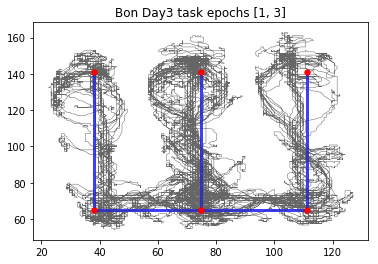

In [14]:
"""This is broken as a function! (since it loses scope); works as script..."""

animal='Bon'
day='Day3'
epoch_ids=[1,3]
# epoch_ids=5

from matplotlib.path import Path

pos = data[animal][day]['pos'][epoch_ids,:]
x0, y0 = pos.min()
dx2, dy = pos.max() - pos.min()
dx = dx2/2

# now offset it a little:
x0, y0 = x0 + 0.3*dx, y0 + 0.1*dy
dx, dy = dx*0.7, dy*0.7

vertices = [
    (x0, y0+dy),
    (x0, y0),
    (x0+dx, y0),
    (x0+2*dx, y0),
    (x0+2*dx, y0+dy),
    (x0+dx, y0),
    (x0+dx, y0+dy)
]

#  W-maze vertex ordering
#
#  1     2     3
#  |     |     |
#  a     b     c
#  |     |     |
#  4--d--5--e--6

vert_order = [0,6,4,1,2,3]

codes = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.MOVETO,
         Path.LINETO,
         ]

path = Path(vertices, codes)

color_list = ['r','g','b','y','m','c','lightblue','lightgreen','lightred','brown','salmon','pink']
fig, ax = plt.subplots()

npl.plot2d(pos, ax=ax, color='0.4', lw=0.5)
plt.title('{} {} task epochs {}'.format(animal, day, epoch_ids))

patch = mpatches.PathPatch(path, facecolor='none', edgecolor='blue', linewidth=3, alpha=0.5)
ax.add_patch(patch)

interactor = PathInteractor(patch, datadict=vertexData)
plt.show()


In [412]:
idx = -1
epoch_ids=[1,3]
epoch_ids=5

In [438]:
"""This is broken as a function! (since it loses scope); works as script..."""
idx +=1
animal, day = sessions[idx]

from matplotlib.path import Path

pos = data[animal][day]['pos'][epoch_ids,:]
x0, y0 = pos.min()
dx2, dy = pos.max() - pos.min()
dx = dx2/2

# now offset it a little:
x0, y0 = x0 + 0.3*dx, y0 + 0.1*dy
dx, dy = dx*0.7, dy*0.7

vertices = [
    (x0, y0+dy),
    (x0, y0),
    (x0+dx, y0),
    (x0+2*dx, y0),
    (x0+2*dx, y0+dy),
    (x0+dx, y0),
    (x0+dx, y0+dy)
]

#  W-maze vertex ordering
#
#  1     2     3
#  |     |     |
#  a     b     c
#  |     |     |
#  4--d--5--e--6

vert_order = [0,6,4,1,2,3]

codes = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.MOVETO,
         Path.LINETO,
         ]

path = Path(vertices, codes)

color_list = ['r','g','b','y','m','c','lightblue','lightgreen','lightred','brown','salmon','pink']
fig, ax = plt.subplots()

npl.plot2d(pos, ax=ax, color='0.4', lw=0.5)
plt.title('{} {} task epochs {}'.format(animal, day, epoch_ids))

patch = mpatches.PathPatch(path, facecolor='none', edgecolor='blue', linewidth=3, alpha=0.5)
ax.add_patch(patch)

interactor = PathInteractor(patch, datadict=vertexData)
plt.show()


IndexError: list index out of range

In [441]:
vertexjar = nel.ResultsContainer(vertexData=vertexData)
vertexjar.save_pkl('FrankLabVertexData.nel')